<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TPU/GPU-detection" data-toc-modified-id="TPU/GPU-detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TPU/GPU detection</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configuration</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Datasets" data-toc-modified-id="Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Datasets</a></span><ul class="toc-item"><li><span><a href="#Data-pipeline" data-toc-modified-id="Data-pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data pipeline</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation</a></span></li><li><span><a href="#Train/validation-split" data-toc-modified-id="Train/validation-split-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Train/validation split</a></span></li><li><span><a href="#Dataset-visualizations" data-toc-modified-id="Dataset-visualizations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Dataset visualizations</a></span></li></ul></li><li><span><a href="#Keras" data-toc-modified-id="Keras-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Keras</a></span><ul class="toc-item"><li><span><a href="#Learning-rate-scheduler" data-toc-modified-id="Learning-rate-scheduler-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Learning rate scheduler</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Validation" data-toc-modified-id="Validation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation</a></span></li></ul></div>

In [63]:
!pip install -q tensorflow-addons==0.9.1
!pip install -q image-classifiers==1.0.0
# !pip install -q efficientnet==1.1.0

In [64]:
import math, re, os, glob, time, random
from collections import namedtuple
from functools import partial

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from classification_models.tfkeras import Classifiers
# import efficientnet.tfkeras as efn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from kaggle_datasets import KaggleDatasets

import seaborn as sns
from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

K = tf.keras.backend
L = tf.keras.layers
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# TPU/GPU detection

In [65]:
# Detect hardware, return appropriate distribution strategy
def get_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

    print("REPLICAS: ", strategy.num_replicas_in_sync)
    
    return strategy

strategy = get_strategy()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Configuration

In [66]:
# data setup
SEED = 1029
GCS_PATH = KaggleDatasets().get_gcs_path('shopee-product-detection-open')  # used in tpu kernel
GCS_PATH_2 = KaggleDatasets().get_gcs_path('sp-tfrecords')
DATA_PATH = '../input/shopee-product-detection-open/'
CLASSES = sorted(os.listdir(DATA_PATH+'train/train/train'))
IM_SZ = 224  # 320, 384, 448, 512
IMAGE_SIZE = [IM_SZ, IM_SZ]
WHICH_FOLD = 0

# training setup
EPOCHS = 7
BATCH_SIZE = 16 * strategy.num_replicas_in_sync    # 128
LR = 1e-4

random.seed(SEED)
np.random.seed(SEED)

## Functions

In [67]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data, to_deprocess=False):
    try:
        images, labels = data
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
    except:
        images = data
        numpy_images = images.numpy()
        numpy_labels = None
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    if to_deprocess:
        numpy_images = np.stack([deprocessing(im) for im in numpy_images])
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_sample(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, to_deprocess=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch, to_deprocess)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    else:
        labels = np.argmax(labels, -1)
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_sample(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot, figsize=(8,10)):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=figsize)
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Datasets

In [68]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

NUM_TRAIN_IMAGES = train_df.shape[0]
NUM_TEST_IMAGES = test_df.shape[0]

print('Num. of train images:', NUM_TRAIN_IMAGES)
print('Num. of test images:', NUM_TEST_IMAGES)

Num. of train images: 105390
Num. of test images: 12186


In [69]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH_2 + '/train/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH_2 + '/test/*.tfrec')

## Data pipeline

In [70]:
# for caffe preproc mode
MEAN_C = [123.68, 116.779, 103.939]

# for torch preproc mode
MEAN_T = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def decode_image(image, mode=None):
    assert mode in (None, 'tf', 'torch', 'caffe'), "mode must be one of None, 'tf', 'torch', 'caffe'"
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    if mode is None:
        return image
    if mode == 'tf':
        image = image / 255.0  # convert image to floats in [0, 1] range
    if mode == 'torch':
        image = image / 255.0
        image = (image - MEAN_T) / STD
    if mode == 'caffe':
        image = image - MEAN_C
    return image

def deprocessing(image, mode=None):
    assert mode in (None, 'tf', 'torch', 'caffe'), "mode must be one of None, 'tf', 'torch', 'caffe'"
    def rescale(x):
        low, high = x.min(), x.max()
        x_rescaled = (x - low) / (high - low)
        return x_rescaled
    if mode is None or mode == 'tf':
        return rescale(image)
    if mode == 'torch':
        return rescale(image * STD + MEAN_T)
    if mode == 'caffe':
        return rescale(image + MEAN_C)

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.one_hot(tf.cast(example['label'], tf.int32), len(CLASSES))
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "filename": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    filename = example['filename']
    return image, filename

def data_augment(image, label, p_hsv=0.6, p_affine=0.75, p_cutout=0.):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    r_hsv = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    r_affine = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    r_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    image = tf.image.random_flip_left_right(image)
    if r_hsv < p_hsv:
        image = tf.image.random_brightness(image, 0.15)
        image = tf.image.random_saturation(image, 0.8, 2.3)
        image = tf.image.random_contrast(image, 0.8, 1.3)
    if r_affine < p_affine:
        image = shift_scale_rotate(image, h_shift=0.1*IM_SZ, w_shift=0.1*IM_SZ)
    if r_cutout < p_cutout:
        image = cutout(image)
    
    return image, label

def get_training_dataset():
    dataset = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=AUTO)
    return (
        dataset
        .map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        # .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(100000)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

def get_validation_dataset():
    dataset = tf.data.TFRecordDataset(VALID_FILENAMES, num_parallel_reads=AUTO)
    return (
        dataset
        .map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

def get_test_dataset():
    dataset = tf.data.TFRecordDataset(TEST_FILENAMES, num_parallel_reads=AUTO)
    return (
        dataset
        .map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
    )

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

## Data augmentation

In [71]:
def transform(image, matrix, border_mode=0):
    BORDERS = ['constant', 'nearest']
    border_mode = BORDERS[border_mode]
    
    DIM = IMAGE_SIZE[0]
    C = DIM // 2
    
    # LIST DESTINATION PIXEL INDICES
    y, x = tf.meshgrid(tf.range(DIM), tf.range(DIM))
    x_c, y_c = tf.reshape(x - C, [-1]), tf.reshape(y - C, [-1])
    x, y = tf.reshape(x, [-1]), tf.reshape(y, [-1])
    if matrix.shape[0] == 2:
        coord = tf.stack( [x_c,y_c] )   # (2, DIM*DIM)
    else:
        z = tf.ones([DIM*DIM], dtype='int32')
        coord = tf.stack( [x_c,y_c,z] )   # (3, DIM*DIM)
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    coord_pr = tf.matmul(matrix, tf.cast(coord, dtype='float32'))
    coord_pr = tf.cast(tf.round(coord_pr[:2,:] + C), dtype='int32')   # (2, DIM*DIM)
    
    # FIND ORIGIN PIXEL VALUES
    if border_mode == 'constant':
        x_pr, y_pr = coord_pr[0,:], coord_pr[1,:]
        outside_ind = tf.logical_or( tf.logical_or(y_pr>DIM-1 , y_pr<0), tf.logical_or(x_pr>DIM-1 , x_pr<0))

        x_pr = tf.boolean_mask(x_pr, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        y_pr = tf.boolean_mask(y_pr, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        x    = tf.boolean_mask(x, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        y    = tf.boolean_mask(y, tf.logical_not(outside_ind))   # (<DIM*DIM, )

        coord_pr = tf.transpose( tf.stack( [x_pr, y_pr] ) )   # (<DIM*DIM, 2)
        coord = tf.cast(tf.transpose( tf.stack( [x, y] ) ), 'int64')   # (<DIM*DIM, 2)

        im_channels = tf.split(image, 3, axis=-1)
        rot_channels = []
        for im_val in im_channels:
            rot_val = tf.squeeze(tf.gather_nd(im_val, coord_pr), axis=-1)   # (<DIM*DIM, )
            rot = tf.SparseTensor(coord, rot_val, [DIM, DIM])
            rot_channels.append(tf.sparse.to_dense(rot, default_value=0, validate_indices=False))

        rot_image = tf.transpose(tf.stack(rot_channels), [1, 2, 0])   # (DIM, DIM, 3)
    
    if border_mode == 'nearest':
        coord_pr = tf.clip_by_value(coord_pr, 0, DIM - 1)   # (2, DIM*DIM)
        rot_image = tf.reshape( tf.gather_nd(image, tf.transpose(coord_pr)), [DIM, DIM, 3] )
    
    return rot_image

def rotate(image, angle):
    angle = math.pi * angle / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    t_matrix = tf.reshape( tf.stack([c1,s1, -s1,c1]), [2,2] )
    return transform(image, t_matrix)

def shear(image, angle):
    angle = math.pi * angle / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0],s1, zero[0],c1]), [2,2] )
    return transform(image, t_matrix)

def zoom(image, height_zoom, width_zoom):
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0]/height_zoom,zero[0], zero[0],one[0]/width_zoom]), [2,2] )
    return transform(image, t_matrix)

def shift(image, height_shift, width_shift):
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0],zero[0],height_shift, zero[0],one[0],width_shift, zero[0],zero[0],one[0]]), [3,3] )
    return transform(image, t_matrix)

def shift_scale_rotate(image, rotation=15, shear=8, h_zoom=1, w_zoom=1, h_shift=20, w_shift=20):
    rot = rotation * tf.random.normal([1], dtype='float32')
    shr = shear * tf.random.normal([1], dtype='float32')
    h_zoom = h_zoom + tf.random.normal([1], dtype='float32') / 10.
    w_zoom = w_zoom + tf.random.normal([1], dtype='float32') / 10.
    h_shift = h_shift * tf.random.normal([1], dtype='float32')
    w_shift = w_shift * tf.random.normal([1], dtype='float32')
    
    angle = math.pi * rot / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rot_matrix = tf.reshape( tf.concat([c1,s1, -s1,c1], axis=0), [2,2] )
    
    angle = math.pi * shr / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    shr_matrix = tf.reshape( tf.concat([one,s1, zero,c1], axis=0), [2,2] )
    
    z_matrix = tf.reshape( tf.concat([one/h_zoom,zero, zero,one/w_zoom], axis=0), [2,2] )
    
    t_matrix = K.dot(K.dot(rot_matrix, shr_matrix), z_matrix)
    t_image = transform(image, t_matrix)
    
    s_matrix = tf.reshape( tf.concat([one,zero,h_shift, zero,one,w_shift, zero,zero,one], axis=0), [3,3] )
    return transform(t_image, s_matrix)

def cutout(image, min_height=0.4, min_width=0.4, max_height=0.6, max_width=0.6):
    DIM = IMAGE_SIZE[0]
    
    cut_height = tf.cast(tf.round(tf.random.uniform([], minval=min_height*DIM, maxval=max_height*DIM)), 'int32')
    cut_width = tf.cast(tf.round(tf.random.uniform([], minval=min_width*DIM, maxval=max_width*DIM)), 'int32')
    x_min = tf.random.uniform([], minval=-cut_width//2, maxval=DIM-1-cut_width//2, dtype='int32')
    x_max = x_min + cut_width
    y_min = tf.random.uniform([], minval=-cut_height//2, maxval=DIM-1-cut_height//2, dtype='int32')
    y_max = y_min + cut_height
    if x_min < 0:
        cut_width -= 0 - x_min
        x_min = tf.clip_by_value(x_min, 0, x_max)
    if y_min < 0:
        cut_height -= 0 - y_min
        y_min = tf.clip_by_value(y_min, 0, y_max)
    if x_max > DIM:
        cut_width -= x_max - DIM
        x_max = tf.clip_by_value(x_max, x_min, DIM)
    if y_max > DIM:
        cut_height -= y_max - DIM
        y_max = tf.clip_by_value(y_max, y_min, DIM)
    
    cut_area = tf.zeros([cut_height, cut_width, 3], dtype='float32')
    pad_top = y_min
    pad_bottom = DIM - y_max
    pad_left = x_min
    pad_right = DIM - x_max
    cut_mask = tf.pad(cut_area, [[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    
    cut_image = tf.multiply(image, cut_mask)
    return cut_image

## Train/validation split

In [72]:
VALID_FILENAMES = [TRAINING_FILENAMES[WHICH_FOLD]]
TRAIN_FILENAMES = TRAINING_FILENAMES[:WHICH_FOLD] + TRAINING_FILENAMES[WHICH_FOLD+1:]

In [73]:
NUM_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
STEPS_PER_EPOCH = math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
# VALIDATION_STEPS = math.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAIN_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 100121 training images, 5269 validation images, 12186 unlabeled test images


## Dataset visualizations

In [74]:
# val_dataset = get_validation_dataset()
# val_dataset = val_dataset.unbatch().batch(5)
# val_batch = iter(val_dataset)
# images, labels = next(val_batch)

In [75]:
# plt.figure(figsize=(5,5))
# display_one_sample(images[1], '', (1,1,1));

In [76]:
# plt.figure(figsize=(5,5))
# display_one_sample(shift_scale_rotate(images[1]), '', (1,1,1));

In [77]:
# plt.figure(figsize=(5,5))
# display_one_sample(cutout(images[1]), '', (1,1,1));

In [78]:
# # Peek at training data
# train_dataset = get_training_dataset()
# train_dataset = train_dataset.unbatch().batch(20)
# train_batch = iter(train_dataset)

In [79]:
# # run this cell again for next set of images
# # longer because of the augmentation process
# display_batch_of_images(next(train_batch), to_deprocess=True)

In [80]:
# val_dataset = get_validation_dataset()
# val_dataset = val_dataset.unbatch().batch(20)
# val_batch = iter(val_dataset)

In [81]:
# # run this cell again for next set of images
# display_batch_of_images(next(val_batch), to_deprocess=True)

In [82]:
# # peer at test data
# test_dataset = get_test_dataset()
# test_dataset = test_dataset.unbatch().batch(20)
# test_batch = iter(test_dataset)

In [83]:
# # run this cell again for next set of images
# display_batch_of_images(next(test_batch), to_deprocess=True)

# Keras

## Learning rate scheduler

In [94]:
# 我自己寫的版本
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    SCHEDULES = set(['cosine', 'linear', 'linear_cosine'])
    
    def __init__(self, iterations, sched_profile='cosine', max_lr=3e-3, 
                div_factor=25, warmup=0.3, final_div=None):
        
        assert sched_profile in self.SCHEDULES  # 這裡怪怪?? SCHEDULES 前面放self.  怪怪的
        self.sched_profile = sched_profile
        
        self.max_lr = max_lr                           # lr at middle point
        
        self.div_factor = div_factor
        self.init_lr = self.max_lr/self.div_factor      # lr at start point
        
        self.final_div = final_div
        if self.final_div is None:
            self.final_div = self.div_factor*1e4
        self.final_lr = self.max_lr/self.final_div      # lr at end point
        
        
        self.total_iteration = iterations
        self.up_iteration = int(self.total_iteration*warmup)
        self.down_iteration = self.total_iteration - self.up_iteration
        
        
    def _annealing_linear(self, start, end, pct):
        return start + pct * (end-start)
    
    
    def _annealing_cos(self, start, end, pct):
        cos_out = (tf.math.cos(tf.constant(np.pi) + tf.constant(np.pi)*pct) + 1) / 2
        return start + cos_out*(end-start)
    
    def _annealing_function(self):
        if self.sched_profile == 'cosine':
            return self._annealing_cos
        if self.sched_profile == 'linear':
            return self._annealing_linear
    
    @tf.function
    def __call__(self, step):
        if self.sched_profile == 'linear_cosine':
            if step <= self.up_iteration:
                pct = step / self.up_iteration
                curr_lr = self._annealing_linear(self.init_lr, self.max_lr, pct)
            else:
                pct = step / self.down_iteration
                curr_lr = self._annealing_cos(self.max_lr, self.final_lr, pct)
                
        if self.sched_profile != 'linear_cosine':
            if step <= self.up_iteration:
                pct = step / self.up_iteration
                anneal = self._annealing_function()
                curr_lr = anneal(self.max_lr, self.final_lr, pct)
            else:
                pct = step / self.down_iteration
                anneal = self._annealing_function()
                curr_lr = anneal(self.max_lr, self.final_lr, pct)
                
        return curr_lr
    
    def plot_sched(self):
        fig_sz = (6,4)
        subplts = (111,)
        
        init_lr = self.init_lr
        max_lr = self.max_lr
        final_lr = self.final_lr
        if self.sched_profile == 'linear_cosine':
            anneal_up = self._annealing_linear
            anneal_down = self._annealing_cos
        else:
            anneal_up = anneal_down = self._annealing_function()
        lrs = [anneal_up(init_lr, max_lr, it/self.up_iteration) for it in range(self.up_iteration)] + \
              [anneal_down(max_lr, final_lr, it/self.down_iteration) for it in range(self.down_iteration)]
        
        plt.subplots(figsize=fig_sz)
        plt.tight_layout()
        ax = plt.subplot(subplts[0])
        ax.plot(range(self.total_iteration), lrs)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Learning rate')
        
        plt.show()

In [95]:
# class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#     SCHEDULES = set(['cosine', 'linear', 'linear_cosine'])
    
#     def __init__(self, iterations, sched_profile='cosine', max_lr=3e-3,
#                  div_factor=25, warmup=0.3, final_div=None):

#         assert sched_profile in self.SCHEDULES
#         self.sched_profile = sched_profile

#         self.max_lr = max_lr
#         self.init_lr = max_lr/div_factor

#         self.final_div = final_div
#         if self.final_div is None: self.final_div = div_factor*1e4
#         self.final_lr = self.max_lr/self.final_div

#         self.total_iteration = iterations
#         self.up_iteration = int(self.total_iteration * warmup)
#         self.down_iteration = self.total_iteration - self.up_iteration

#     def _annealing_cos(self, start, end, pct):
#         cos_out = tf.math.cos(tf.constant(np.pi) * pct) + 1
#         return end + (start-end)/2 * cos_out

#     def _annealing_linear(self, start, end, pct):
#         return start + pct * (end-start)
    
#     def _annealing_function(self):
#         if self.sched_profile == 'cosine':
#             return self._annealing_cos
#         if self.sched_profile == 'linear':
#             return self._annealing_linear
    
#     @tf.function
#     def __call__(self, step):
#         if self.sched_profile != 'linear_cosine':
#             anneal = self._annealing_function()

#         if step <= self.up_iteration:
#             if self.sched_profile == 'linear_cosine':
#                 anneal = self._annealing_linear
#             pct = step / self.up_iteration
#             curr_lr = anneal(self.init_lr, self.max_lr, pct)
#         else:
#             if self.sched_profile == 'linear_cosine':
#                 anneal = self._annealing_cos
#             pct = (step-self.up_iteration) / self.down_iteration
#             curr_lr = anneal(self.max_lr, self.final_lr, pct)

#         return curr_lr
    
#     def plot_sched(self):
#         fig_sz = (6,4)
#         subplts = (111,)
        
#         init_lr = self.init_lr
#         max_lr = self.max_lr
#         final_lr = self.final_lr
#         if self.sched_profile == 'linear_cosine':
#             anneal_up = self._annealing_linear
#             anneal_down = self._annealing_cos
#         else:
#             anneal_up = anneal_down = self._annealing_function()
#         lrs = [anneal_up(init_lr, max_lr, it/self.up_iteration) for it in range(self.up_iteration)] + \
#               [anneal_down(max_lr, final_lr, it/self.down_iteration) for it in range(self.down_iteration)]
        
#         plt.subplots(figsize=fig_sz)
#         plt.tight_layout()
#         ax = plt.subplot(subplts[0])
#         ax.plot(range(self.total_iteration), lrs)
#         ax.set_xlabel('Iteration')
#         ax.set_ylabel('Learning rate')
        
#         plt.show()

## Model

In [96]:
strategy = get_strategy()

with strategy.scope():
#     pretrained_model = efn.EfficientNetB1(weights='noisy-student', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#     pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    resnet, _ = Classifiers.get('resnet50')
    pretrained_model = resnet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True  # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        pretrained_model,
        L.GlobalAveragePooling2D(),
        L.Dense(len(CLASSES), activation='softmax')
    ])
    
    lr_sched = LRSchedule(STEPS_PER_EPOCH * EPOCHS, max_lr=LR)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_sched),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(len(CLASSES), average='macro', threshold=None)]
    )
    
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )
    
    model.summary()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 7, 7, 2048)        23546057  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 42)                86058     
Total params: 23,632,115
Trainable params: 23,586,541
Non-trainable params: 45,574
_________________________________________________________________


In [97]:
# lr_sched.plot_sched()

## Training

In [98]:
start_time = time.time()

history = model.fit(
    get_training_dataset(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=get_validation_dataset(),
    callbacks=[ckpt_callback]
)

keras_fit_training_time = time.time() - start_time
print("KERAS FIT TRAINING TIME: {:0.1f}s".format(keras_fit_training_time))

model.load_weights('best_model.h5')

Epoch 1/7
783/783 [==============================] - 89s 113ms/step - loss: 1.8086 - categorical_accuracy: 0.6426 - f1_score: 0.6404 - val_loss: 1.5315 - val_categorical_accuracy: 0.7428 - val_f1_score: 0.7416
Epoch 2/7
783/783 [==============================] - 72s 92ms/step - loss: 1.5091 - categorical_accuracy: 0.7375 - f1_score: 0.7367 - val_loss: 1.4297 - val_categorical_accuracy: 0.7715 - val_f1_score: 0.7705
Epoch 3/7
783/783 [==============================] - 76s 97ms/step - loss: 1.4614 - categorical_accuracy: 0.7529 - f1_score: 0.7532 - val_loss: 1.4248 - val_categorical_accuracy: 0.7745 - val_f1_score: 0.7733
Epoch 4/7
783/783 [==============================] - 74s 94ms/step - loss: 1.3794 - categorical_accuracy: 0.7821 - f1_score: 0.7825 - val_loss: 1.3893 - val_categorical_accuracy: 0.7861 - val_f1_score: 0.7842
Epoch 5/7
783/783 [==============================] - 73s 93ms/step - loss: 1.3348 - categorical_accuracy: 0.7949 - f1_score: 0.7952 - val_loss: 1.3826 - val_catego

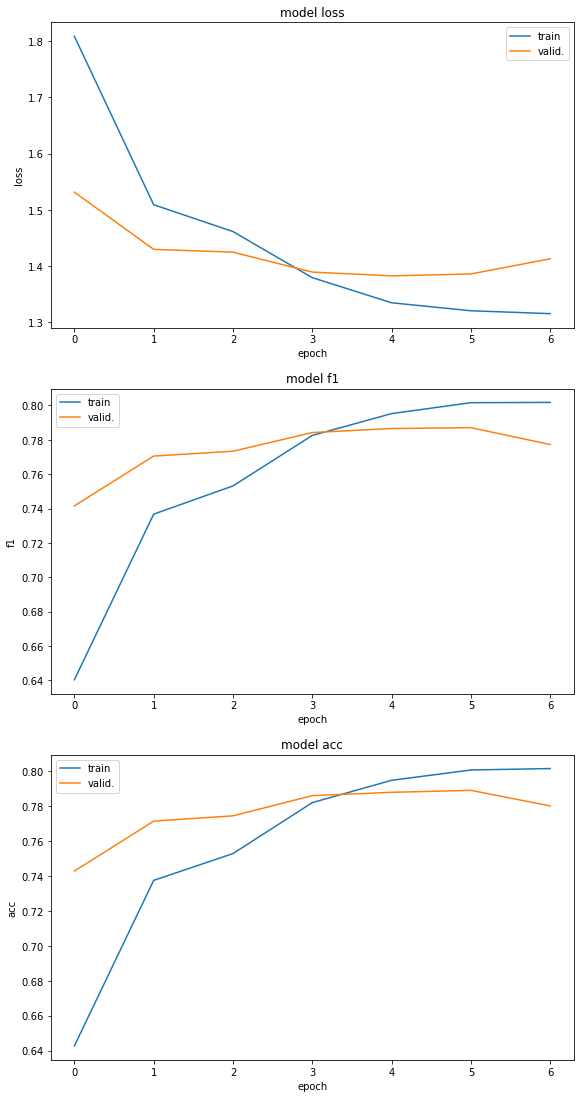

In [99]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 311, figsize=(8,15))
display_training_curves(history.history['f1_score'], history.history['val_f1_score'], 'f1', 312)
display_training_curves(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'acc', 313)

# Validation

In [100]:
%%time

val_dataset = get_validation_dataset()
images_ds = val_dataset.map(lambda image, label: image)
labels_ds = val_dataset.map(lambda image, label: label).unbatch()
valid_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
valid_labels = np.argmax(valid_labels, -1)

valid_preds = model.predict(images_ds)
valid_preds = np.argmax(valid_preds, axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fc945e570e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fc976517d40>. Note that functions defined in certain environments, like the interactive Python shell do no

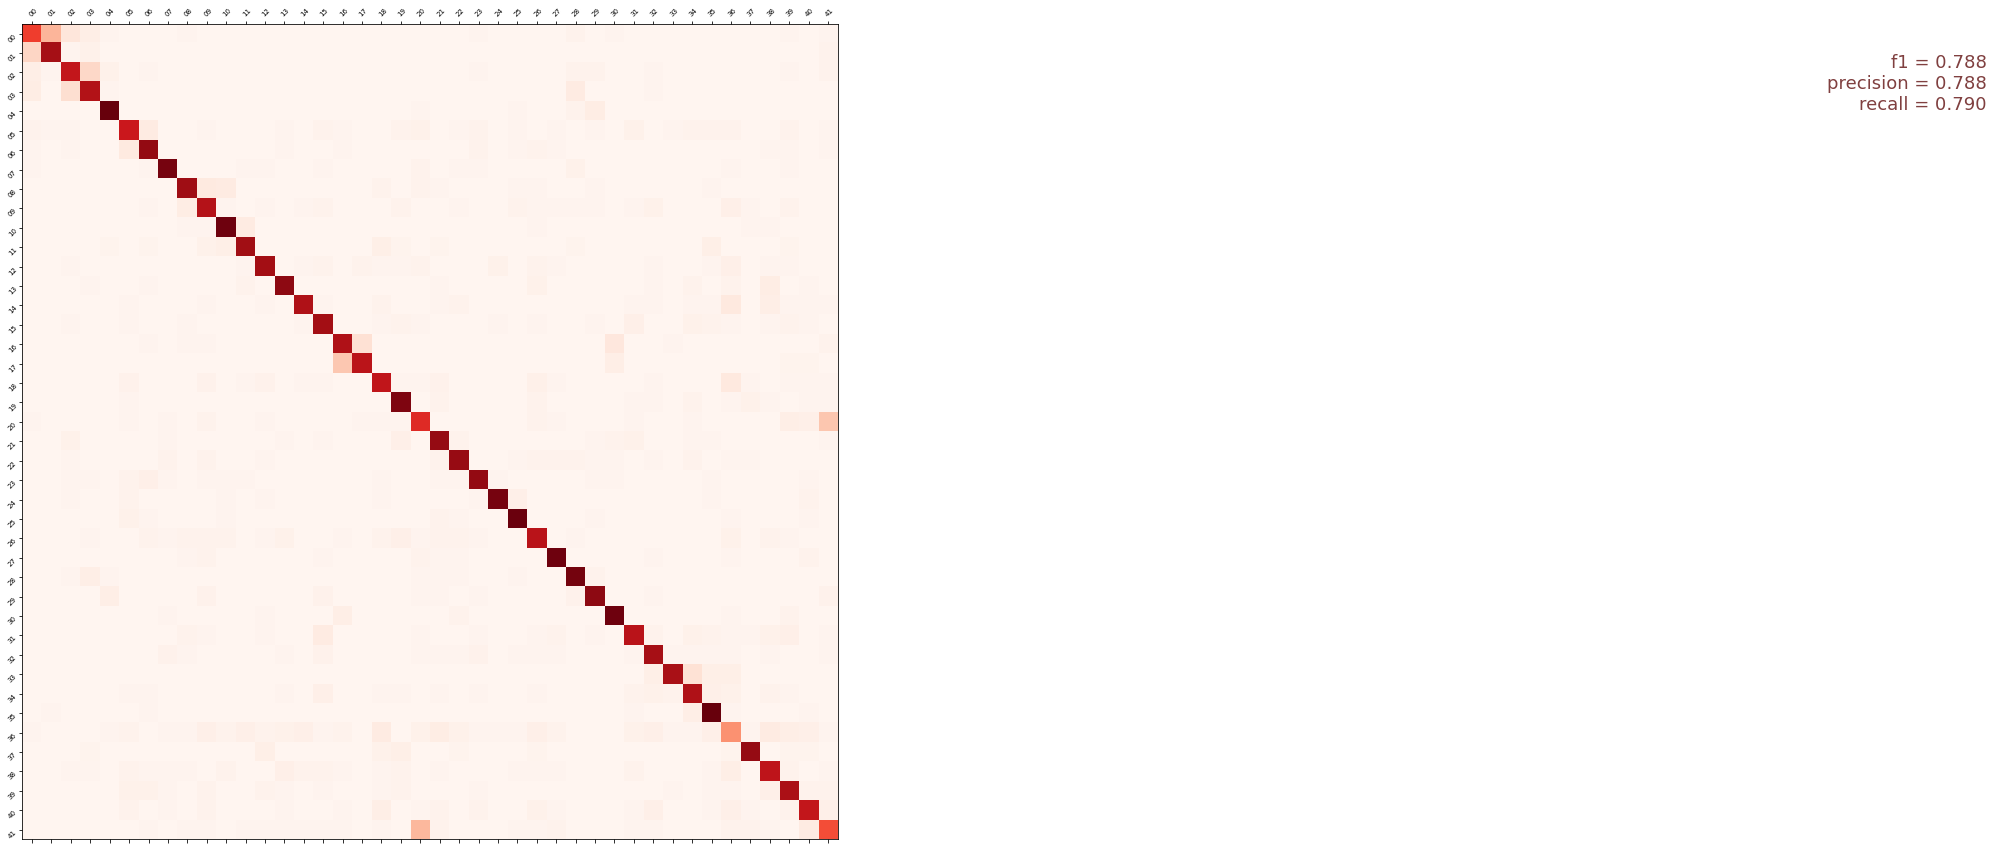

accuracy: 0.790, f1 score: 0.788, precision: 0.788, recall: 0.790


In [101]:
val_acc = accuracy_score(valid_labels, valid_preds)
val_f1 = f1_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')
val_prec = precision_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')
val_rec = recall_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')

cmat = confusion_matrix(valid_labels, valid_preds, labels=range(len(CLASSES)))
cmat = (cmat.T / cmat.sum(axis=1)).T  # normalized

display_confusion_matrix(cmat, val_f1, val_prec, val_rec)
print('accuracy: {:.3f}, f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(val_acc, val_f1, val_prec, val_rec))

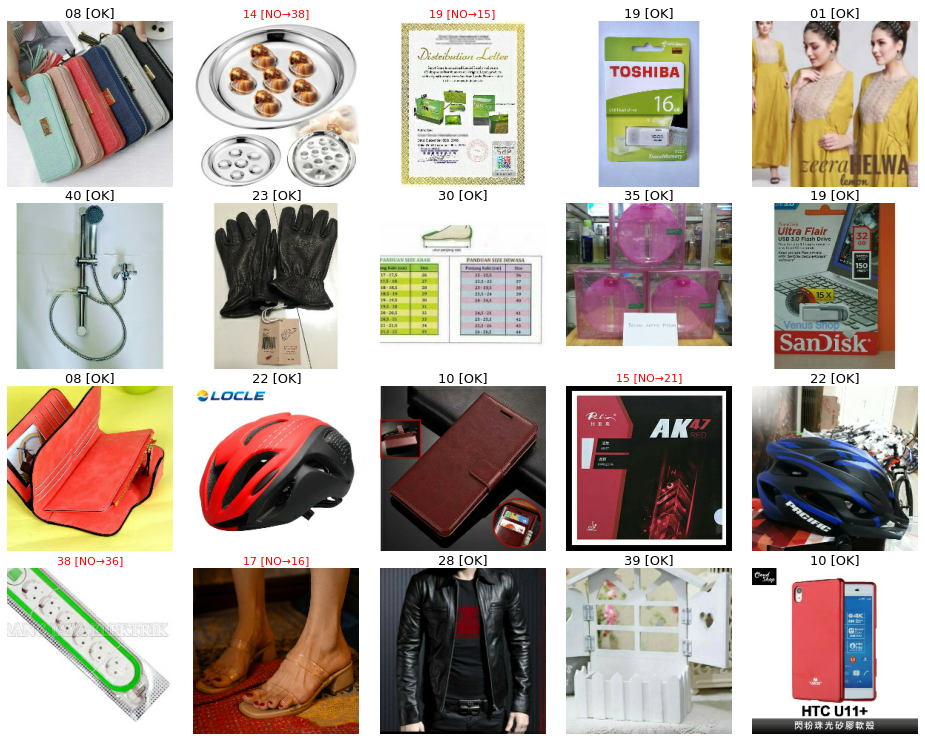

In [102]:
val_dataset = get_validation_dataset()
val_dataset = val_dataset.unbatch().batch(20)
val_batch = iter(val_dataset)
images, labels = next(val_batch)

# run this cell again for next set of images
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions, to_deprocess=True)